In [1]:
import keras
import time
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle

from util_functions import *

In [2]:
DATA_PATH = "../../Data/"
IMG_SIZE = (224, 224)
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

## TEST RESULTS

In [7]:
# generate all the model names with augmentations and kfold numbers
start = "skin_classifier_10_"
models = ["BASIC_", "VGG16_"]
augmentations = ["original_","rotation_","zoom_","crop+flip_","color_"]
kfolds = ["kfold_1", "kfold_2", "kfold_3", "kfold_4", "kfold_5", ]
end = ".keras"

paths = []
for m in models:
    for aug in augmentations:
        for kfold in kfolds:
            paths.append(start+m+aug+kfold+end)
paths

['skin_classifier_10_BASIC_original_kfold_1.keras',
 'skin_classifier_10_BASIC_original_kfold_2.keras',
 'skin_classifier_10_BASIC_original_kfold_3.keras',
 'skin_classifier_10_BASIC_original_kfold_4.keras',
 'skin_classifier_10_BASIC_original_kfold_5.keras',
 'skin_classifier_10_BASIC_rotation_kfold_1.keras',
 'skin_classifier_10_BASIC_rotation_kfold_2.keras',
 'skin_classifier_10_BASIC_rotation_kfold_3.keras',
 'skin_classifier_10_BASIC_rotation_kfold_4.keras',
 'skin_classifier_10_BASIC_rotation_kfold_5.keras',
 'skin_classifier_10_BASIC_zoom_kfold_1.keras',
 'skin_classifier_10_BASIC_zoom_kfold_2.keras',
 'skin_classifier_10_BASIC_zoom_kfold_3.keras',
 'skin_classifier_10_BASIC_zoom_kfold_4.keras',
 'skin_classifier_10_BASIC_zoom_kfold_5.keras',
 'skin_classifier_10_BASIC_crop+flip_kfold_1.keras',
 'skin_classifier_10_BASIC_crop+flip_kfold_2.keras',
 'skin_classifier_10_BASIC_crop+flip_kfold_3.keras',
 'skin_classifier_10_BASIC_crop+flip_kfold_4.keras',
 'skin_classifier_10_BASIC_c

In [15]:
# get validation images and labels
generator = ImageDataGenerator()
validation_data = generator.flow_from_directory( 
        directory=IMAGES_PATH_VALIDATION,
        target_size=IMG_SIZE,
        batch_size=64
)
y_real = to_categorical(validation_data.labels)

def get_stats(path: str) -> str:
    '''
    This function gets statistics row with
    model,augment,kfold,precision,recall,specificity,f1-score,top-1,top-2,top-3
    for a model loaded from keras_models folder
    Arguments:
        path: model path within keras_models folder
    Returns:
        statistics row of statistics
    '''
    model_loaded = keras.models.load_model("output/keras_models/"+path)
    y_pred = model_loaded.predict(validation_data)
    cm = print_confusion_matrix(model_loaded, val_image_path=None, 
                                data=validation_data, supress_print=True)

    mean = cm.mean()
    top_1 = get_top_k_accuracy(y_real, y_pred,1)
    top_2 = get_top_k_accuracy(y_real, y_pred,2)
    top_3 = get_top_k_accuracy(y_real, y_pred,3)
    
    model = path[19:]
    model = model[:model.index("_")]
    augment = path[25:]
    augment = augment[:augment.index("_")]
    kfold = path[-7]
    row = "{},{},{},{},{},{},{},{},{},{}\n"
    
    row = row.format(model,augment,kfold,mean["precision"],mean["recall"],
               mean["specificity"],mean["f1-score"],
               top_1,top_2,top_3)
    return row

# Get statistics for all of the models from Basic and VGG16 models KFolds
# Convert to a dataframe
data = "model,augment,kfold,precision,recall,specificity,f1-score,top-1,top-2,top-3\n"
for path in tqdm(paths):
    data+= get_stats(path)
strio = StringIO(data)
df = pd.read_csv(strio,sep=",")
df

Found 1005 images belonging to 7 classes.


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [56:43<00:00, 68.06s/it]


,model,augment,kfold,precision,recall,specificity,f1-score,top-1,top-2,top-3
0,BASIC,original,1,0.143000,0.156171,0.832957,0.142943,0.5721,0.7035,0.8169
1,BASIC,original,2,0.131157,0.138686,0.832657,0.126243,0.5910,0.7144,0.8517
2,BASIC,original,3,0.153557,0.148300,0.839714,0.139900,0.6010,0.7453,0.8667
3,BASIC,original,4,0.138000,0.140171,0.835900,0.128157,0.5980,0.7313,0.8308
4,BASIC,original,5,0.143771,0.141029,0.830686,0.130114,0.5771,0.7423,0.8348
5,BASIC,rotation,1,0.155057,0.147557,0.803129,0.146157,0.4975,0.6378,0.7721
6,BASIC,rotation,2,0.160914,0.144857,0.808071,0.144500,0.4796,0.6279,0.7672
7,BASIC,rotation,3,0.146571,0.140743,0.824229,0.134814,0.5632,0.6935,0.8010
8,BASIC,rotation,4,0.133600,0.144814,0.815543,0.136457,0.5413,0.6945,0.8050
9,BASIC,rotation,5,0.145629,0.151571,0.813743,0.141986,0.5264,0.6637,0.7771


In [117]:
# save dataframe with statistics
df.to_csv("output/test_results.csv")

In [19]:
# separate statistics for Basic and VGG16 models
df_vgg16 = df[df.model=="VGG16"]
df_basic = df[df.model=="BASIC"]

In [27]:
# aggregate mean statistics of Kfolds
df_vgg16_mean = df_vgg16.groupby("augment").agg(np.mean).drop(["kfold"], axis=1)
df_vgg16_mean

,precision,recall,specificity,f1-score,top-1,top-2,top-3
augment,,,,,,,
color,0.138171,0.143377,0.856200,0.116791,0.66410,0.70528,0.76060
crop+flip,0.148017,0.154837,0.817177,0.133060,0.54806,0.66308,0.74608
original,0.147043,0.142706,0.832711,0.135437,0.58490,0.71642,0.79862
rotation,0.139669,0.141343,0.816191,0.136306,0.53074,0.64716,0.74606
zoom,0.136009,0.137837,0.809757,0.131283,0.52934,0.64100,0.73970


In [28]:
# aggregate mean statistics of Kfolds
df_basic_mean = df_basic.groupby("augment").agg(np.mean).drop(["kfold"], axis=1)
df_basic_mean

,precision,recall,specificity,f1-score,top-1,top-2,top-3
augment,,,,,,,
color,0.095320,0.141666,0.855480,0.113963,0.66210,0.69212,0.70948
crop+flip,0.128734,0.133577,0.803737,0.125474,0.52200,0.62088,0.71422
original,0.141897,0.144871,0.834383,0.133471,0.58784,0.72736,0.84018
rotation,0.148354,0.145909,0.812943,0.140783,0.52160,0.66348,0.78448
zoom,0.143186,0.142797,0.776040,0.133817,0.45254,0.58090,0.68716


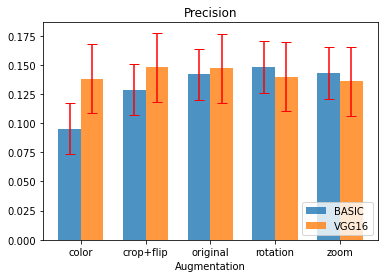

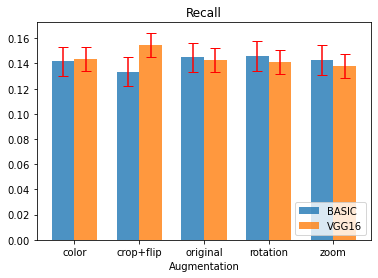

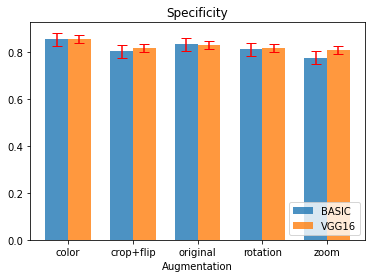

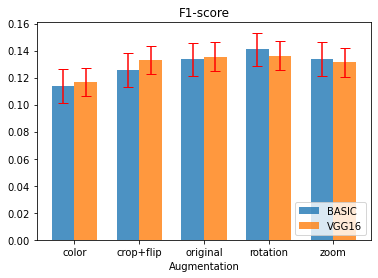

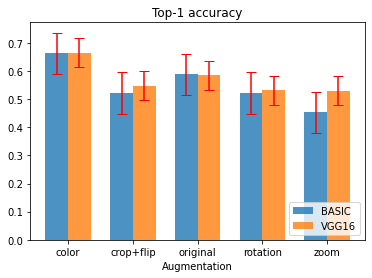

In [7]:
def plot_comparison(metric: str, print_error: bool=True) -> None:
    '''
    This function plots barchart comparisons of metrics between Basic and VGG16 models
    (precision, recall, specificity, f1-score and top-1 accuracy)    
    Arguments:
        metric: select metric for comparison
        print_error: option to exclude standard deviation from the plot
    Returns:
        None
    '''
    width = 0.35
    ind = np.arange(len(df_basic_mean.index))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    basic_std, vgg16_std = None, None
    if print_error:
        basic_std = np.std(df_basic[metric])
        vgg16_std = np.std(df_vgg16[metric])

    ax.bar(ind, df_basic_mean[metric], width, 
           yerr=basic_std, capsize=5, alpha=0.8, ecolor="red")
    ax.bar(ind+width, df_vgg16_mean[metric], width, 
           yerr=vgg16_std, capsize=5, alpha=0.8, ecolor="red")
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels( (df_basic_mean.index) )
    ax.legend( ("BASIC","VGG16"), loc="lower right")
    ax.set_xlabel("Augmentation")
    if "top" in metric:
        metric += " accuracy"
    ax.set_title(metric.capitalize())
    plt.show()
    
plot_comparison("precision")
plot_comparison("recall")
plot_comparison("specificity")
plot_comparison("f1-score")
plot_comparison("top-1")

## Precision-Recal and Receiver Operating Characteristics Plot

In [3]:
# Load results (to continue from before)
df = pd.read_csv("output/test_results.csv", index_col=0)

# separate data between models and aggregate mean
df_vgg16 = df[df.model=="VGG16"]
df_basic = df[df.model=="BASIC"]
df_vgg16_mean = df_vgg16.groupby("augment").agg(np.mean).drop(["kfold"], axis=1)
df_basic_mean = df_basic.groupby("augment").agg(np.mean).drop(["kfold"], axis=1)

In [3]:
# get validation images, labels and define augmentations
generator = ImageDataGenerator()
validation_data = generator.flow_from_directory( 
        directory=IMAGES_PATH_VALIDATION,
        target_size=IMG_SIZE,
        batch_size=64
)
y_real = to_categorical(validation_data.labels)
classes = list(validation_data.class_indices.keys())
augmentations = ["original","rotation","zoom","color","crop+flip"]

Found 1005 images belonging to 7 classes.


In [65]:
def plot_precision_recall(y_real: np.ndarray, pred: np.ndarray, 
                          augmentation: str, model_name: str) -> None:
    '''
    This function plots precision agains recall on the same graph
    and calculates Area Under the Curve score (AUC) for a desired model and augmentation
    Arguments:
        y_real: truth labels
        pred: predicted labels
        augmentation: augmentation name
        model_name: model name
    Returns:
        None
    '''
    precision, recall = dict(), dict()
    plt.figure(figsize=(10,6))
    # plot line for every lesion class
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_real[:, i], pred[:, i])
        plt.plot(recall[i], precision[i], lw=1, label=classes[i])
    auc = roc_auc_score(y_real, pred)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    plt.title("{0} Precision vs. Recall Curve {1} Model AUC:{2:.4f}".format(
            augmentation.capitalize(), model_name, auc))
    plt.show()

In [67]:
def plot_roc_curve(y_real: np.ndarray, pred: np.ndarray, 
                   augmentation: str, model_name: str) -> None:
    '''
    This function plots Receiver Operating Characteristics (ROC)
    and calculates Area Under the Curve score (AUC) for a desired model and augmentation
    Arguments:
        y_real: truth labels
        pred: predicted labels
        augmentation: augmentation name
        model_name: model name
    Returns:
        None
    '''
    fpr, tpr = dict(), dict()
    plt.figure(figsize=(10,6))
    # plot line for every lesion class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_real[:, i], pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=1, label=classes[i])
    auc = roc_auc_score(y_real, pred)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    plt.title("{0} ROC Curve {1} Model AUC:{2:.4f}".format(
            augmentation.capitalize(), model_name, auc))
    plt.show()

In [10]:
def get_predictions(path: str) -> np.ndarray:
    '''
    This function gets predictions based on unseen data from loaded model
    Arguments:
        path: path to a model within keras_models folder
    Returns:
        numpy.ndarray
    '''
    model_loaded = keras.models.load_model("output/keras_models/"+path)
    return model_loaded.predict(validation_data)

In [11]:
def get_all_predictions(model: str) -> dict:
    '''
    This function combines all predictions based on unseen data from model (Basic or VGG16)
    Arguments:
        model: model name (Basic or VGG16)
    Returns:
        dict
    '''
    preds_all = dict()
    
    for name in augmentations:
        preds = []
        for i in range(1,6):
            path = "skin_classifier_10_{0}_{1}_kfold_{2}.keras".format(model, name, i)
            preds.append(get_predictions(path))
        preds = np.mean(preds, axis=0)
        preds_all[name] = preds
    return preds_all

In [89]:
# get predictions for VGG16 and Basic models
predictions_vgg16 = get_all_predictions("VGG16")
predictions_basic = get_all_predictions("BASIC")

In [112]:
# SAVE pickled data
with open("output/predictions_vgg16.pkl", "wb") as f:
    pickle.dump(predictions_vgg16, f)
with open("output/predictions_basic.pkl", "wb") as f:
    pickle.dump(predictions_basic, f)

In [20]:
# LOAD pickled data
with open("output/predictions_vgg16.pkl", "rb") as f:
    predictions_vgg16 = pickle.load(f)
with open("output/predictions_basic.pkl", "rb") as f:
    predictions_basic = pickle.load(f)
'''    ''';

### VGG16 Model

#### Precision-Recall

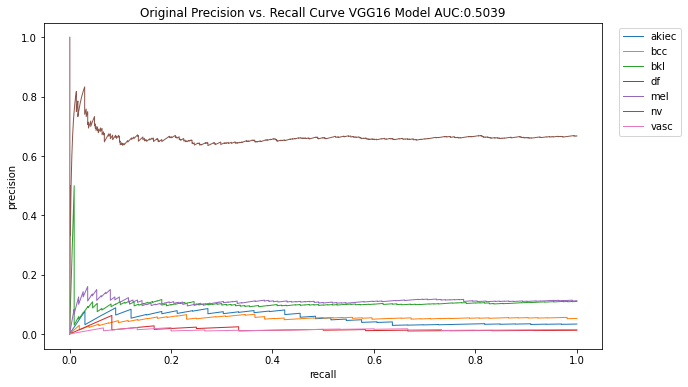

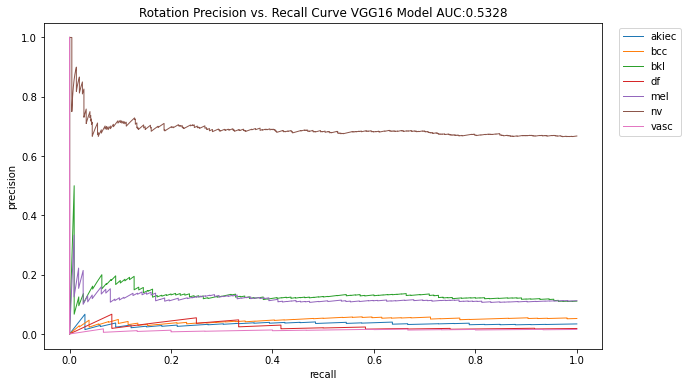

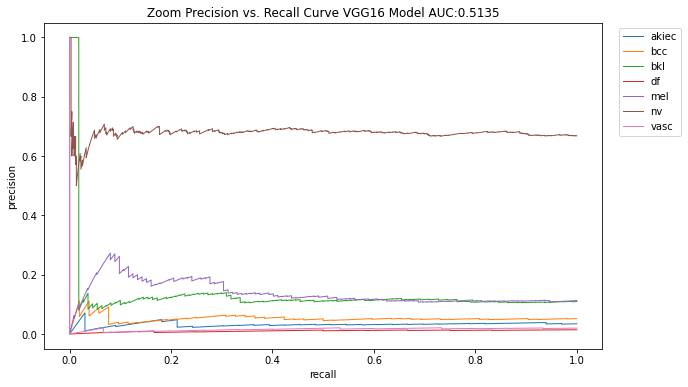

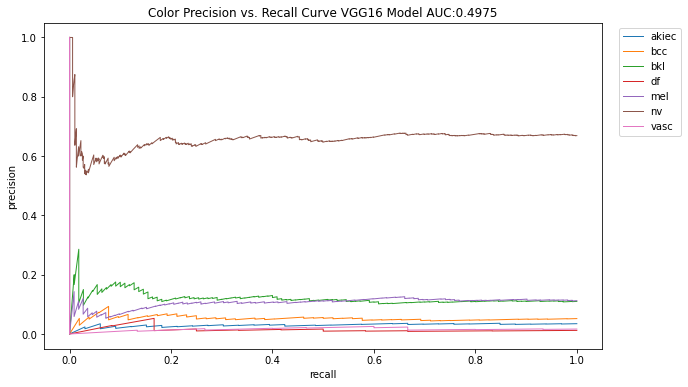

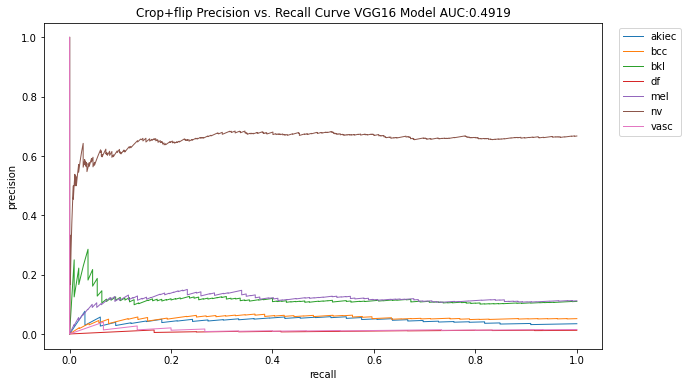

In [66]:
for augment in augmentations:
    plot_precision_recall(y_real, predictions_vgg16[augment], augment, "VGG16")

#### ROC

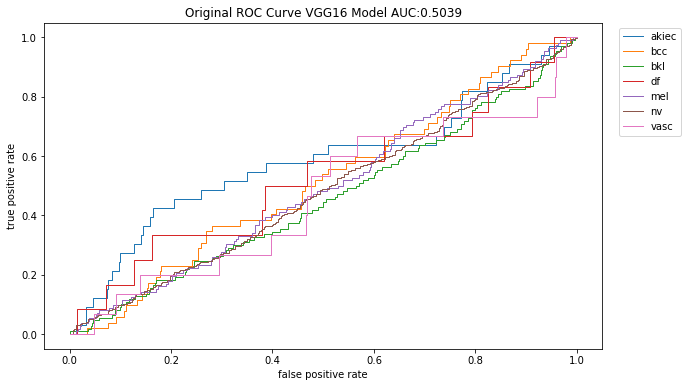

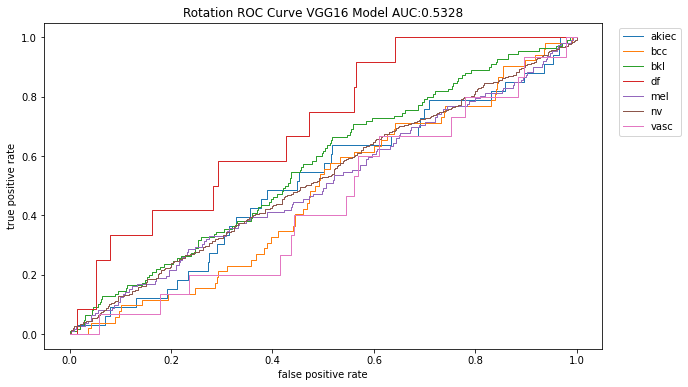

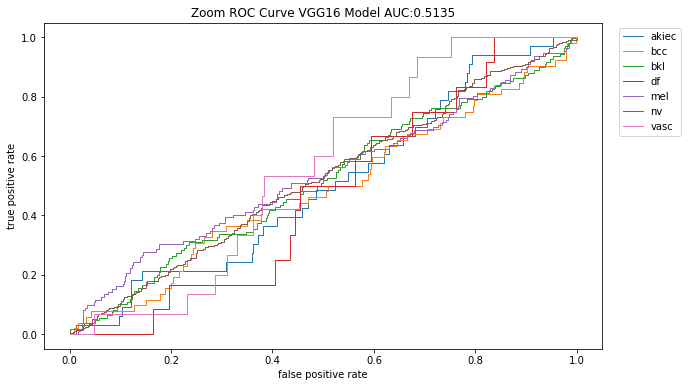

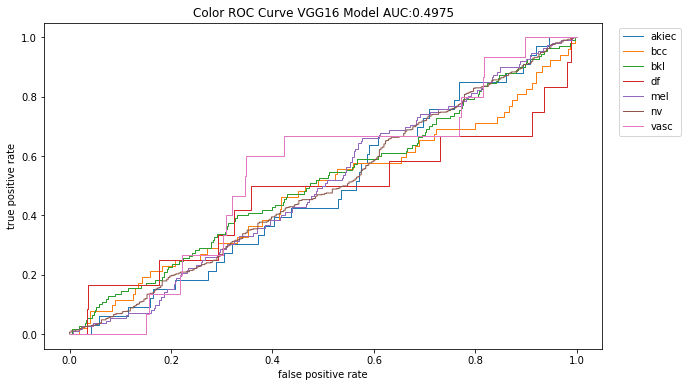

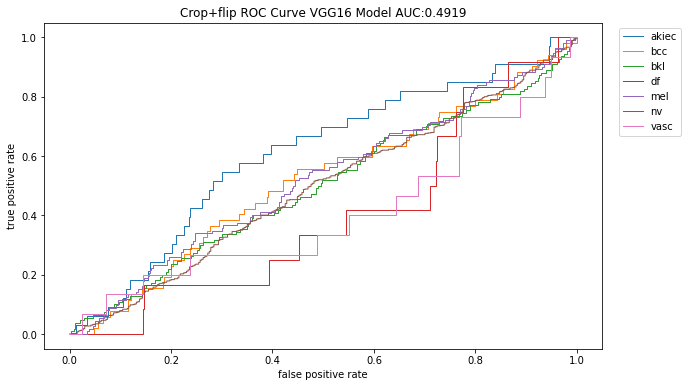

In [68]:
for augment in augmentations:
    plot_roc_curve(y_real, predictions_vgg16[augment], augment, "VGG16")

### Basic Model

#### Precision-Recall

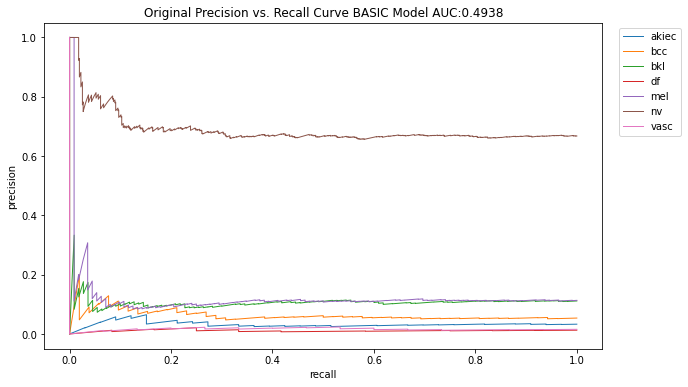

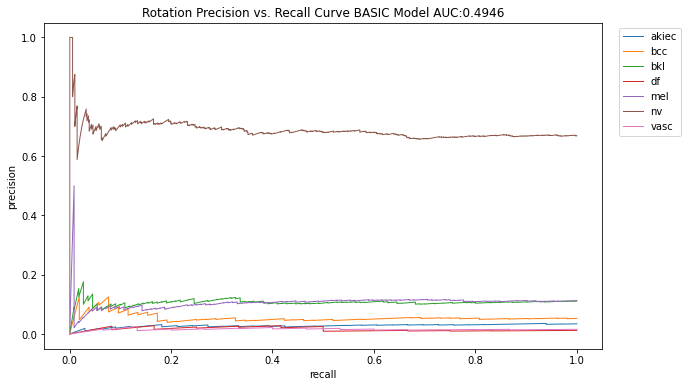

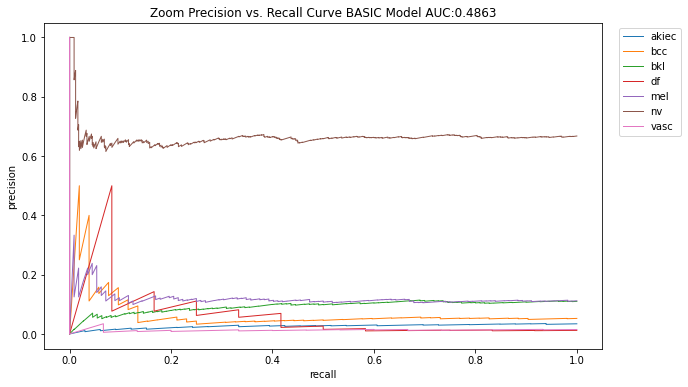

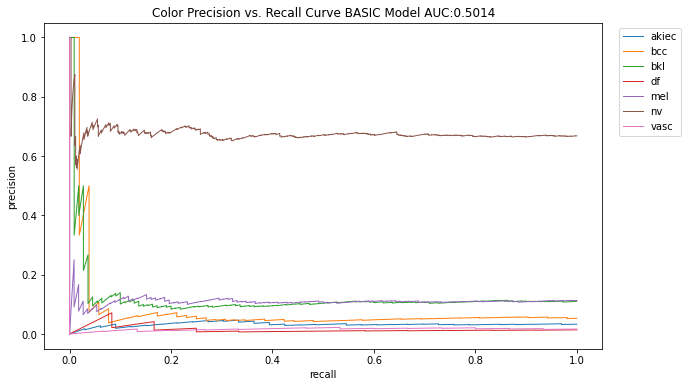

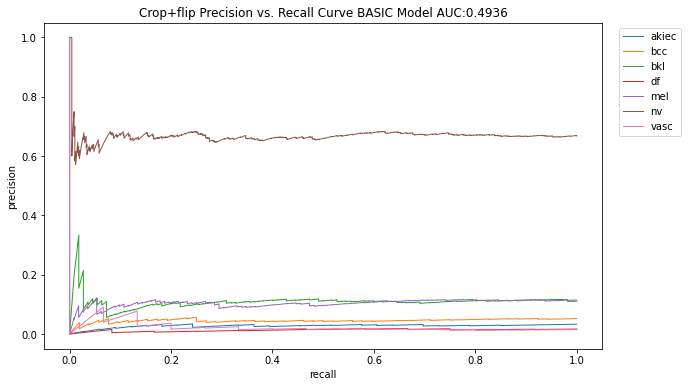

In [69]:
for augment in augmentations:
    plot_precision_recall(y_real, predictions_basic[augment], augment, "BASIC")

#### ROC

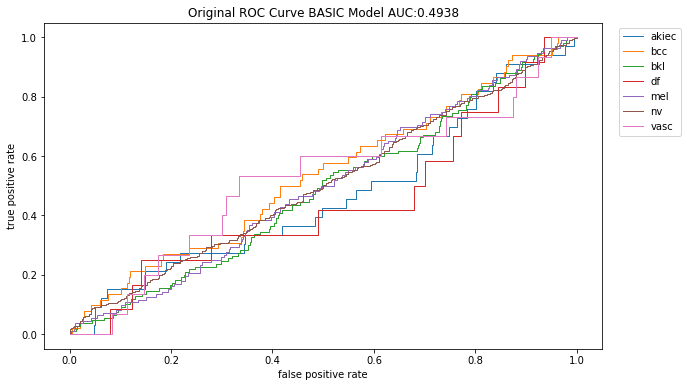

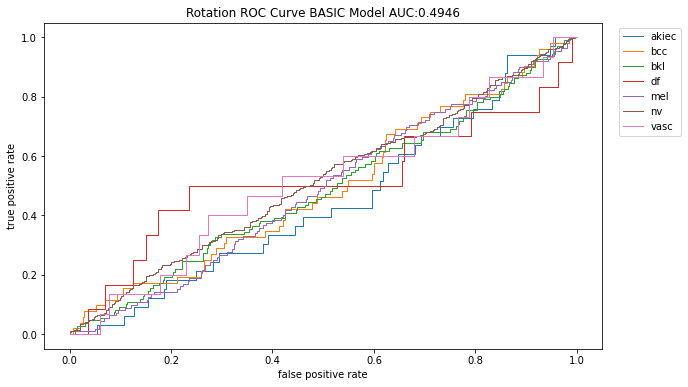

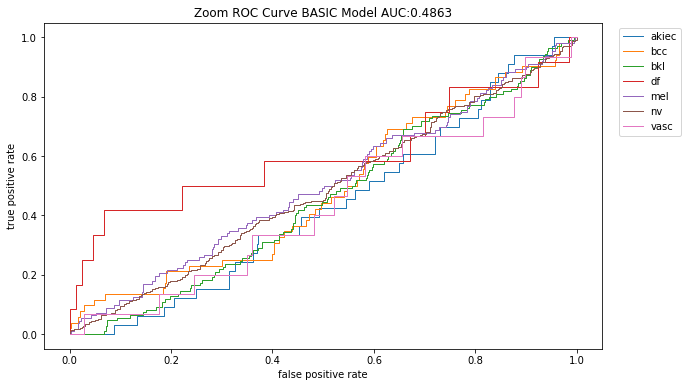

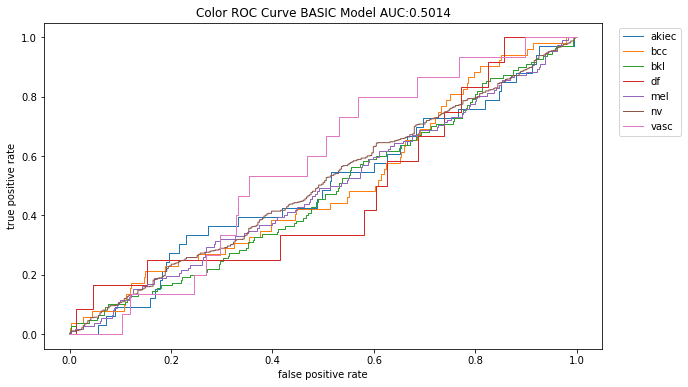

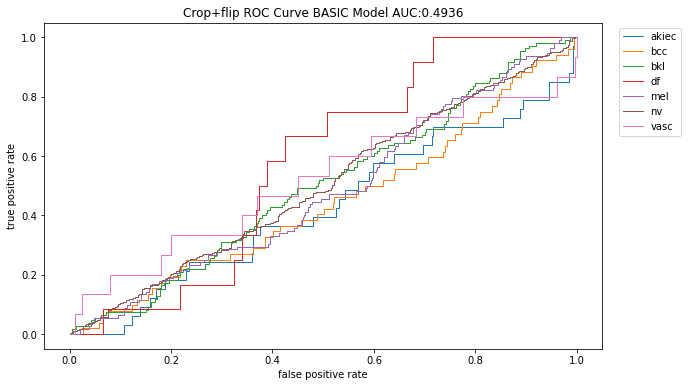

In [70]:
for augment in augmentations:
    plot_roc_curve(y_real, predictions_basic[augment], augment, "BASIC")

## Convolutional Filters for Basic Model

### Original Data

Filters     : 16
Kernel Size : (3, 3)


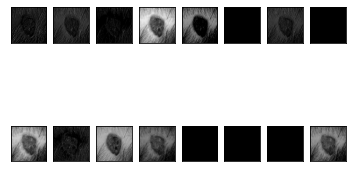

Filters     : 32
Kernel Size : (3, 3)


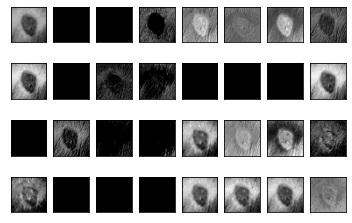

Filters     : 64
Kernel Size : (3, 3)


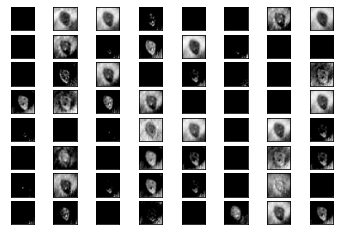

In [6]:
path = "skin_classifier_10_BASIC_original_kfold_3.keras"
model_loaded = keras.models.load_model("output/keras_models/"+path)

print_filters(model_loaded)

### Rotation

Filters     : 16
Kernel Size : (3, 3)


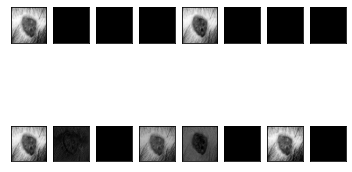

Filters     : 32
Kernel Size : (3, 3)


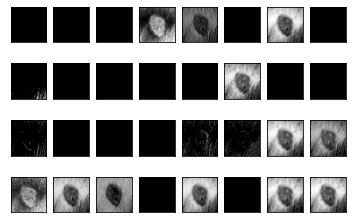

Filters     : 64
Kernel Size : (3, 3)


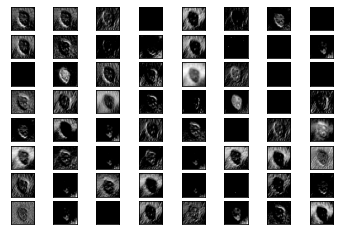

In [5]:
path = "skin_classifier_10_BASIC_rotation_kfold_3.keras"
model_loaded = keras.models.load_model("output/keras_models/"+path)

print_filters(model_loaded)

### Zoom

Filters     : 16
Kernel Size : (3, 3)


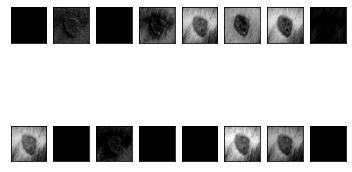

Filters     : 32
Kernel Size : (3, 3)


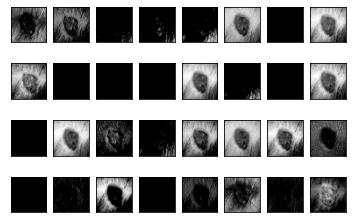

Filters     : 64
Kernel Size : (3, 3)


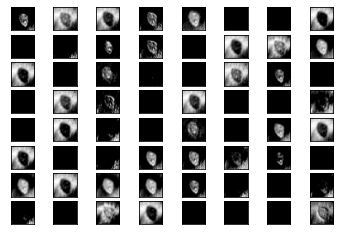

In [7]:
path = "skin_classifier_10_BASIC_zoom_kfold_2.keras"
model_loaded = keras.models.load_model("output/keras_models/"+path)

print_filters(model_loaded)

### Crop and Flip

Filters     : 16
Kernel Size : (3, 3)


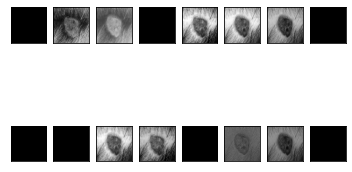

Filters     : 32
Kernel Size : (3, 3)


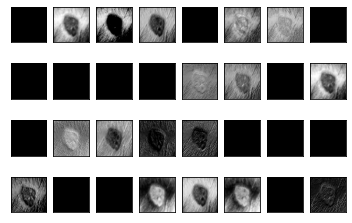

Filters     : 64
Kernel Size : (3, 3)


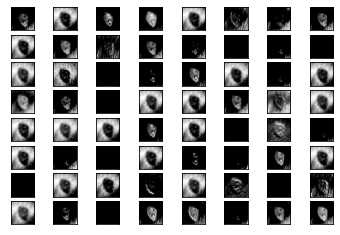

In [8]:
path = "skin_classifier_10_BASIC_crop+flip_kfold_2.keras"
model_loaded = keras.models.load_model("output/keras_models/"+path)

print_filters(model_loaded)

### Color

Filters     : 16
Kernel Size : (3, 3)


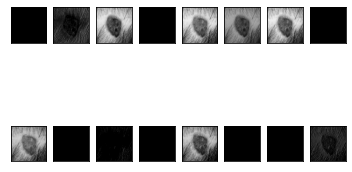

Filters     : 32
Kernel Size : (3, 3)


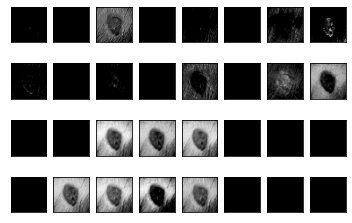

Filters     : 64
Kernel Size : (3, 3)


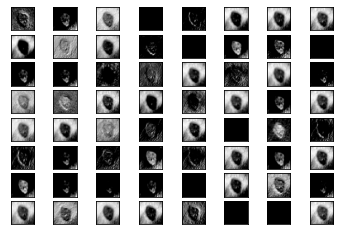

In [10]:
path = "skin_classifier_10_BASIC_color_kfold_4.keras"
model_loaded = keras.models.load_model("output/keras_models/"+path)

print_filters(model_loaded)